In [430]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import os
import re

In [431]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [432]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [433]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [434]:
test['Survived'] = np.NaN
data = train.append(test, ignore_index = True, sort = True)

In [435]:
data.shape

(1309, 12)

In [436]:
data['Fare'].fillna(value = data['Fare'].mean(), inplace = True)

In [437]:
data['FareBin'] = pd.qcut(data.Fare, 4)

In [438]:
data.Cabin = data.Cabin.fillna("U")
data.Embarked = data.Embarked.fillna("S")

In [439]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [440]:
data['Age'] = data[['Age','Pclass']].apply(impute_age,axis=1)

In [441]:
data['Sex'] = data.Sex.map({'male':0, 'female': 1})
data['FareBin'] = data.FareBin.astype('category').cat.codes
data['Embarked'] = data.Embarked.map({'S':0, 'C': 1, 'Q': 2})
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

In [442]:
data['Age'] = data['Age'].astype(int)

In [443]:
data['AgeBin'] = pd.cut(data.Age, 5).cat.codes

In [444]:
data['AgeBin'].unique()

array([1, 2, 3, 0, 4])

In [445]:
data['Title'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

In [446]:
replacementTitle = []

data['Title'] = np.where(data.Title == "Master", 2, data.Sex)
data['TicketFreq'] = data.Ticket.map(lambda x: data[data.Ticket == x].Ticket.count())
data['FareAdj'] = data.Fare/data.TicketFreq/10
data.FamilySize = data.SibSp + data.Parch + 1
data['FamAge'] = data.FamilySize + data.Age/70

data2 = data[(data.PassengerId<= 891) & (data.Title == 0)]
data3 = data[(data.PassengerId > 891) & (data.Title == 0)]

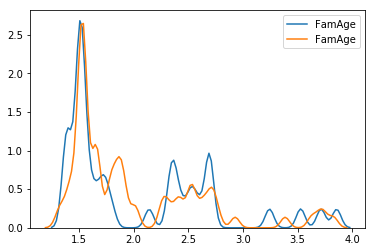

In [447]:
sns.kdeplot(data2[(data2.Survived == 1) & (data2.Pclass == 1)].FamAge, clip = (0,4), bw = 0.04)
sns.kdeplot(data2[(data2.Survived == 0) & (data2.Pclass == 1)].FamAge, clip = (0,4), bw = 0.04)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



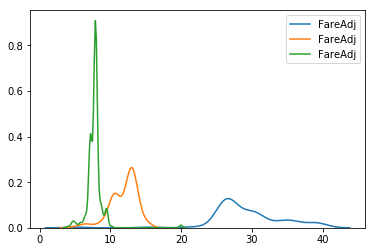

In [448]:
sns.kdeplot(10*data2[data2.Pclass == 1].FareAdj, clip = (0,40))
sns.kdeplot(10*data2[data2.Pclass == 2].FareAdj, clip = (0,40))
sns.kdeplot(10*data2[data2.Pclass == 3].FareAdj, clip = (0,40))

In [449]:
data2.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FareBin,FamilySize,AgeBin,Title,TicketFreq,FareAdj,FamAge
0,22,U,0,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,0,2,1,0,1,0.725000,2.314286
4,35,U,0,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,1,1,2,0,1,0.805000,1.500000
5,24,U,2,8.4583,"Moran, Mr. James",0,6,3,0,0,0.0,330877,1,1,1,0,1,0.845830,1.342857
6,54,E46,0,51.8625,"McCarthy, Mr. Timothy J",0,7,1,0,0,0.0,17463,3,1,3,0,2,2.593125,1.771429
12,20,U,0,8.0500,"Saundercock, Mr. William Henry",0,13,3,0,0,0.0,A/5. 2151,1,1,1,0,1,0.805000,1.285714


In [450]:
train.shape

(891, 12)

In [451]:
data_missing = data.isnull().sum().sort_values(ascending = False)
data_missing.head()

Survived    418
FamAge        0
Sex           0
Cabin         0
Embarked      0
dtype: int64

In [452]:
data.drop(['Name','Ticket','Cabin','PassengerId'], inplace = True, axis = 1)

In [453]:
data.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,FareBin,FamilySize,AgeBin,Title,TicketFreq,FareAdj,FamAge
0,22,0,7.2500,0,3,0,1,0.0,0,2,1,0,1,0.725000,2.314286
1,38,1,71.2833,0,1,1,1,1.0,3,2,2,1,2,3.564165,2.542857
2,26,0,7.9250,0,3,1,0,1.0,1,1,1,1,1,0.792500,1.371429
3,35,0,53.1000,0,1,1,1,1.0,3,2,2,1,2,2.655000,2.500000
4,35,0,8.0500,0,3,0,0,0.0,1,1,2,0,1,0.805000,1.500000


In [454]:
data.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,FareBin,FamilySize,AgeBin,Title,TicketFreq,FareAdj,FamAge
0,22,0,7.2500,0,3,0,1,0.0,0,2,1,0,1,0.725000,2.314286
1,38,1,71.2833,0,1,1,1,1.0,3,2,2,1,2,3.564165,2.542857
2,26,0,7.9250,0,3,1,0,1.0,1,1,1,1,1,0.792500,1.371429
3,35,0,53.1000,0,1,1,1,1.0,3,2,2,1,2,2.655000,2.500000
4,35,0,8.0500,0,3,0,0,0.0,1,1,2,0,1,0.805000,1.500000


In [455]:
y = data['Survived']
data.drop('Survived', axis=1, inplace=True)
X = data

In [456]:
norm = MinMaxScaler()

In [457]:
X = norm.fit_transform(X)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype int8, int64, float64 were all converted to float64 by MinMaxScaler.



In [458]:
X.shape

(1309, 14)

In [459]:
X

array([[0.275     , 0.        , 0.01415106, ..., 0.        , 0.05660423,
        0.12100139],
       [0.475     , 0.5       , 0.13913574, ..., 0.1       , 0.27827147,
        0.14325452],
       [0.325     , 0.        , 0.01546857, ..., 0.        , 0.06187428,
        0.02920723],
       ...,
       [0.475     , 0.        , 0.01415106, ..., 0.        , 0.05660423,
        0.04589708],
       [0.3       , 0.        , 0.01571255, ..., 0.        , 0.06285021,
        0.02642559],
       [0.3       , 0.5       , 0.0436405 , ..., 0.2       , 0.05818733,
        0.22114047]])

In [460]:
X_train = X[0:891,:]

In [461]:
X_train.shape

(891, 14)

In [462]:
X_test = X[891:,:]

In [463]:
X_test.shape

(418, 14)

In [464]:
y.shape

(1309,)

In [465]:
y_train = y[0:891]

In [466]:
y_test = y[891:]

In [467]:
lr = LogisticRegression()

In [468]:
lr.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [469]:
y_pred = lr.predict(X_test)

In [470]:
y_actual = pd.read_csv('../input/gender_submission.csv')

In [471]:
y_binary = y_pred>.5

In [472]:
y_actual.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [473]:
y_actual_binary = y_actual['Survived']

In [474]:
cm = confusion_matrix(y_actual_binary, y_binary)

In [475]:
cm

array([[240,  26],
       [ 11, 141]])

In [476]:
accuracy = accuracy_score(y_actual_binary, y_binary)*100

In [477]:
accuracy

91.14832535885168